<a href="https://colab.research.google.com/github/Jawad280/lifehack/blob/main/Lifehack2024-prophet-with-holiday-support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
df = pd.read_csv('/content/restaurant-1-orders.csv')
df.rename(columns={
    'Order Number': 'order_number',
    'Order Date': 'order_date',
    'Item Name': 'item_name',
    'Quantity': 'quantity',
    'Product Price': 'product_price',
    'Total products': 'total_products'
}, inplace=True)
grouped_bydish = df.groupby('item_name')['quantity'].sum().reset_index()
sorted_df = grouped_bydish.sort_values(by='quantity', ascending=False)
top_20_items = sorted_df.head(20)['item_name']
top_20_items
df['order_date'] = pd.to_datetime(df['order_date'] ,format='%d/%m/%Y %H:%M').dt.date

In [26]:
min_date = df['order_date'].min()
max_date = df['order_date'].max()

# Calculate the date range
date_range = max_date - min_date

# Find the split date (80% of the date range)
split_date = min_date + pd.Timedelta(days=0.8 * date_range.days)
grouped_data = df[df['item_name'] == 'Plain Papadum'].groupby(['order_date'])['quantity'].sum().reset_index()
# Split the DataFrame into training and testing sets
train = grouped_data.loc[grouped_data['order_date'] <= split_date].copy()
test = grouped_data.loc[grouped_data['order_date'] > split_date].copy()
train.head()
#test.head()


,order_date,quantity
0,2016-03-17,6
1,2016-03-18,7
2,2016-03-19,5
3,2016-03-20,2
4,2016-03-23,8


In [40]:
import holidays
start_year = min_date.year
end_year = max_date.year

# Fetch UK holidays
uk_holidays = holidays.UK(years=range(start_year, end_year+1))

# Convert to DataFrame
holiday_df = pd.DataFrame([
    {'ds': date, 'holiday': name}
    for date, name in sorted(uk_holidays.items())
])

In [27]:
train_prophet = train.reset_index() \
    .rename(columns={'order_date':'ds',
                     'quantity':'y'})

test_prophet = test.reset_index() \
    .rename(columns={'order_date':'ds',
                     'quantity':'y'})

In [44]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzker6zvt/804_0m41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzker6zvt/k52amk2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30124', 'data', 'file=/tmp/tmpzker6zvt/804_0m41.json', 'init=/tmp/tmpzker6zvt/k52amk2a.json', 'output', 'file=/tmp/tmpzker6zvt/prophet_model3hv1u2j2/prophet_model-20240531231415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 143 ms, sys: 4.75 ms, total: 148 ms
Wall time: 224 ms


In [45]:
test_fcst = model.predict(test_prophet)
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-21,12.166403,6.150093,22.042430,12.166403,12.166403,0.0,0.0,0.0,0.0,...,-0.224951,-0.224951,-0.224951,2.076103,2.076103,2.076103,0.0,0.0,0.0,14.017555
1,2018-10-22,12.173204,4.214348,20.058824,12.173204,12.173204,0.0,0.0,0.0,0.0,...,-2.271466,-2.271466,-2.271466,2.038969,2.038969,2.038969,0.0,0.0,0.0,11.940707
2,2018-10-23,12.180006,3.435122,19.177322,12.180006,12.180006,0.0,0.0,0.0,0.0,...,-3.255246,-3.255246,-3.255246,1.982092,1.982092,1.982092,0.0,0.0,0.0,10.906852
3,2018-10-24,12.186808,3.923452,19.556043,12.186808,12.186808,0.0,0.0,0.0,0.0,...,-2.329977,-2.329977,-2.329977,1.905832,1.905832,1.905832,0.0,0.0,0.0,11.762662
4,2018-10-25,12.193609,3.450484,18.525587,12.193609,12.193609,0.0,0.0,0.0,0.0,...,-3.113319,-3.113319,-3.113319,1.810834,1.810834,1.810834,0.0,0.0,0.0,10.891123


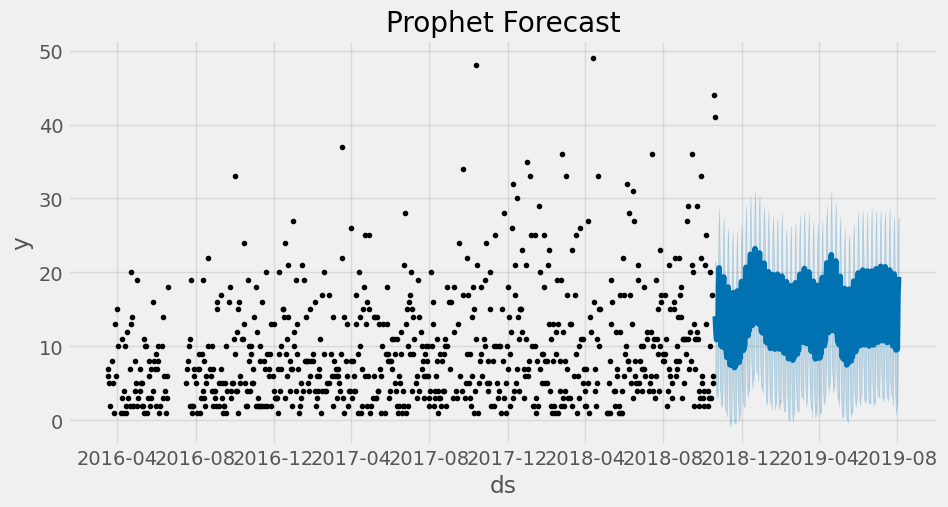

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

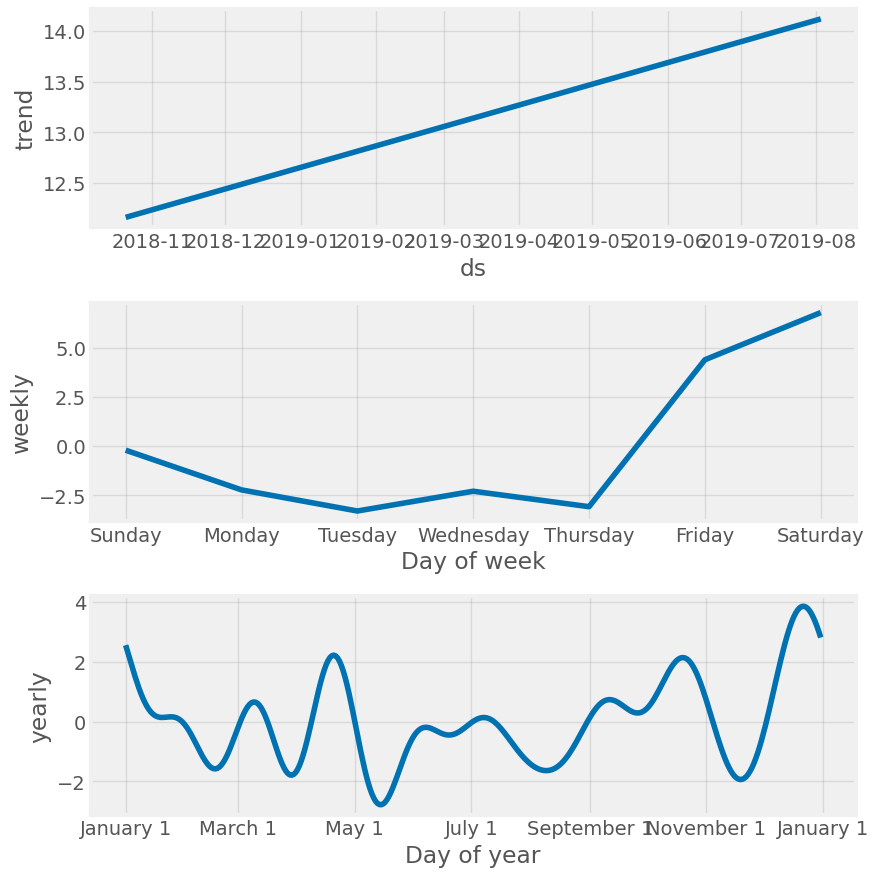

In [32]:
fig = model.plot_components(test_fcst)
plt.show()

In [46]:
mean_absolute_percentage_error(y_true=test['quantity'],
                   y_pred=test_fcst['yhat'])

109.0142035927825